## 执行

result_visualize_cvpr_ly.ipynb 前三个代码段更方便一些的平替。

命令行样例：


```bash
# CIFAR-10
python ./result_analysis/gen_result_visualize_to_csv.py --noise_rate 0.25 --noise_type symmetric --dataset cifar-10
python ./result_analysis/gen_result_visualize_to_csv.py --noise_rate 0.5 --noise_type symmetric --dataset cifar-10
python ./result_analysis/gen_result_visualize_to_csv.py --noise_rate 0.75 --noise_type symmetric --dataset cifar-10

# FLOWER-102
python ./result_analysis/gen_result_visualize_to_csv.py --noise_rate 0.25 --noise_type symmetric --dataset flower-102
python ./result_analysis/gen_result_visualize_to_csv.py --noise_rate 0.5 --noise_type symmetric --dataset flower-102
python ./result_analysis/gen_result_visualize_to_csv.py --noise_rate 0.75 --noise_type symmetric --dataset flower-102

# CIFAR-100
python ./result_analysis/gen_result_visualize_to_csv.py --noise_rate 0.25 --noise_type asymmetric --dataset cifar-100
python ./result_analysis/gen_result_visualize_to_csv.py --noise_rate 0.5 --noise_type asymmetric --dataset cifar-100
python ./result_analysis/gen_result_visualize_to_csv.py --noise_rate 0.75 --noise_type asymmetric --dataset cifar-100

# PET-37
python ./result_analysis/gen_result_visualize_to_csv.py --noise_rate 0.25 --noise_type asymmetric --dataset pet-37
python ./result_analysis/gen_result_visualize_to_csv.py --noise_rate 0.5 --noise_type asymmetric --dataset pet-37
python ./result_analysis/gen_result_visualize_to_csv.py --noise_rate 0.75 --noise_type asymmetric --dataset pet-37


````

跑完模型后，可以跑上面这个代码生成绘图需要的数据，然后绘图。

In [1]:
import argparse
import sys
import pandas as pd
import os

sys.path.append(os.path.abspath(".."))

import torch
import numpy as np
from configs import settings
from core_model.custom_model import ClassifierWrapper, load_custom_model
from core_model.dataset import get_dataset_loader
from core_model.train_test import model_forward

set_noise_ratio = "0.75"
set_noise_type = "asymmetric"
# 0.5 对称 CRUL,ELR,GJS,wfisher的名字为efficientnet_s;发现fisher_new,FT_prune_bi没用

cifar_model_name = "efficientnet_s"
other_model_name = "wideresnet50"

# raw疑似pretrain?
set_basic_name = "pretrain,inctrain"
set_LNL_name = (
    "Coteaching,Coteachingplus,Decoupling,DISC,ELR,GJS,JoCoR,NegativeLearning,PENCIL"
)
set_MU_name = "FT,GA,GA_l1,wfisher"
set_OUR_name = "CRUL"

set_uni_name = f"{set_basic_name},{set_LNL_name},{set_MU_name},{set_OUR_name}"


set_dataset = "pet-37"
set_model_suffix = "restore"
set_batch_size = 64


def execute():
    case = settings.get_case(set_noise_ratio, set_noise_type)
    uni_names = set_uni_name
    uni_names = [uni_names] if uni_names is None else uni_names.split(",")
    num_classes = settings.num_classes_dict[set_dataset]

    _, _, test_loader = get_dataset_loader(
        set_dataset,
        "test",
        None,
        batch_size=set_batch_size,
        shuffle=False,
    )
    _, _, noisy_loader = get_dataset_loader(
        set_dataset,
        "train_noisy",
        case,
        batch_size=set_batch_size,
        shuffle=False,
        label_name="train_noisy_true_label",
    )

    results_data = []

    for uni_name in uni_names:
        print(f"Evaluating {uni_name}:")
        dict_temp = {}
        model_name = cifar_model_name
        if set_dataset == "cifar-10" or set_dataset == "cifar-100":
            model_name = cifar_model_name
        else:
            model_name = other_model_name

        loaded_model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(loaded_model, num_classes)

        if uni_name == "pretrain":
            model_ckpt_path = settings.get_ckpt_path(
                set_dataset,
                "",
                model_name,
                model_suffix="pretrain",
                unique_name=uni_name,
            )
        elif uni_name == "inctrain":
            model_ckpt_path = settings.get_ckpt_path(
                set_dataset,
                case,
                model_name,
                model_suffix="inc_train",
                unique_name="",
            )
        else:
            model_ckpt_path = settings.get_ckpt_path(
                set_dataset,
                case,
                model_name,
                model_suffix=set_model_suffix,
                unique_name=uni_name,
            )
        print(f"Loading model from {model_ckpt_path}")
        checkpoint = torch.load(model_ckpt_path)
        model.load_state_dict(checkpoint, strict=False)
        # print(f"Evaluating test_data:")
        # results, embedding = model_test(test_loader, model)
        # print("Results: %.4f" % results)
        torch.cuda.empty_cache()
        print(f"Evaluating train_noisy_data:")
        n_results, n_embedding = model_test(noisy_loader, model)
        # print("Results: %.4f" % results)
        # print("Results: ", n_results)
        dict_temp = {"uni_name": uni_name, **n_results}
        results_data.append(dict_temp)

    df = pd.DataFrame(results_data)
    return df


def model_test(data_loader, model, device="cuda"):
    eval_results = {}

    predicts, probs, embedding, labels = model_forward(
        data_loader, model, device, output_embedding=True, output_targets=True
    )

    # global acc
    global_acc = np.mean(predicts == labels)
    eval_results["global"] = global_acc.item()

    # error_rate
    eval_results["error_rate"] = 1 - eval_results["global"]
    # class acc
    label_list = sorted(list(set(labels)))
    for label in label_list:
        cls_index = labels == label
        class_acc = np.mean(predicts[cls_index] == labels[cls_index])
        eval_results["label_" + str(label.item())] = class_acc.item()

    return eval_results, embedding

In [2]:

results=pd.DataFrame()
results=execute()


Loading /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy
Loading /nvme/szh/code/tta-mr/data/pet-37/gen/nr_0.75_nt_asymmetric_cvpr/train_noisy_data.npy
Evaluating pretrain:
Loading model from /nvme/szh/code/tta-mr/ckpt/pet-37/pretrain/wideresnet50_pretrain.pth


<ipython-input-1-0320069b7983>:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_ckpt_path)


Evaluating train_noisy_data:
Evaluating inctrain:
Loading model from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.75_nt_asymmetric_cvpr/wideresnet50_inc_train.pth
Evaluating train_noisy_data:
Evaluating Coteaching:
Loading model from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.75_nt_asymmetric_cvpr/Coteaching/wideresnet50_restore.pth
Evaluating train_noisy_data:
Evaluating Coteachingplus:
Loading model from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.75_nt_asymmetric_cvpr/Coteachingplus/wideresnet50_restore.pth
Evaluating train_noisy_data:
Evaluating Decoupling:
Loading model from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.75_nt_asymmetric_cvpr/Decoupling/wideresnet50_restore.pth
Evaluating train_noisy_data:
Evaluating DISC:
Loading model from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.75_nt_asymmetric_cvpr/DISC/wideresnet50_restore.pth
Evaluating train_noisy_data:
Evaluating ELR:
Loading model from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.75_nt_asymmetric_cvpr/ELR/wideresnet50_restore.pth
Evaluating train_nois

## 分析

In [3]:
# results.to_csv('visualize_results_cvpr/cifar10_0.5_sym.csv')
# results.to_csv('visualize_results_cvpr/cifar10_0.25_sym.csv')
#results.to_csv('visualize_results_cvpr/cifar10_0.75_sym.csv')

# results.to_csv('visualize_results_cvpr/flower_0.5_sym.csv')
#results.to_csv('visualize_results_cvpr/flower_0.25_sym.csv')
# results.to_csv('visualize_results_cvpr/flower_0.75_sym.csv')


#results.to_csv('visualize_results_cvpr/cifar100_0.5_asym.csv')
#results.to_csv('visualize_results_cvpr/cifar100_0.25_asym.csv')
# results.to_csv('visualize_results_cvpr/cifar100_0.75_asym.csv')

# results.to_csv('visualize_results_cvpr/pet_0.5_asym.csv')
# results.to_csv('visualize_results_cvpr/pet_0.25_asym.csv')
results.to_csv('visualize_results_cvpr/pet_0.75_asym.csv')

In [4]:
# set corresponding color for each uni_name
import matplotlib.pyplot as plt

set_basic_names = ["retrain", "retrain_ls", "retrain_sam", "raw"]
set_LNL_names = [
    "Coteaching",
    "Coteachingplus",
    "Decoupling",
    "DISC",
    "ELR",
    "GJS",
    "JoCoR",
    "NegativeLearning",
    "PENCIL",
]
set_MU_names = ["finetune", "FT", "FT_l1", "FT_prune", "GA", "GA_l1", "wfisher"]
set_OUR_names = ["CRUL"]

# 生成配色方案
set_basic_colors = plt.cm.Blues(np.linspace(0.3, 0.5, len(set_basic_names)))
set_LNL_colors = plt.cm.Greens(np.linspace(0.3, 0.8, len(set_LNL_names)))
set_MU_colors = plt.cm.Purples(np.linspace(0.3, 0.7, len(set_MU_names)))
set_OUR_colors = ["#ff1493"]  # 深粉色调

# 创建字典
uni_color_dict = {}
# 将颜色和 uni_name 配对
for name, color in zip(set_basic_names, set_basic_colors):
    uni_color_dict[name] = color
for name, color in zip(set_LNL_names, set_LNL_colors):
    uni_color_dict[name] = color
for name, color in zip(set_MU_names, set_MU_colors):
    uni_color_dict[name] = color
for name, color in zip(set_OUR_names, set_OUR_colors):
    uni_color_dict[name] = color

In [7]:
# import matplotlib.pyplot as plt
# dataframes = [results,results,results,results] 
# labels = ['Cifar-10', 'Cifar-100', 'Flower-102', 'Oxford-IIIT Pet'] 
# fig, axs = plt.subplots(2, 2, figsize=(12, 8)) 

# for i, (df, label) in enumerate(zip(dataframes, labels)):
#     ax = axs[i // 2, i % 2]
#     for j, (method, global_val) in enumerate(zip(df['uni_name'], df['global'])):
#         ax.bar(method, global_val, color=uni_color_dict[method], label=method if i == 0 else "",width=0.9) 
#     ax.set_title(f'{label}')
#     # ax.set_xlabel('Algorithm') 
#     ax.set_ylabel('Global Value')
#     ax.set_xticks([])
#     # ax.grid(True,linestyle='--',alpha=0.7)

# handles, labels = [], [] 
# for ax in axs.flat: 
#     h, l = ax.get_legend_handles_labels() 
#     handles.extend(h) 
#     labels.extend(l) 

# n_cols = 4 # 图例列数 
# fig.legend(handles, labels, loc='upper center', ncol=n_cols, bbox_to_anchor=(0.5, -0.1), title="Methods")

# #整体标题
# fig.suptitle('ERROR RATE ON DIFFERENT DATASETS')

# # 调整布局 
# plt.tight_layout(rect=[0, 0, 1, 0.96])  
# fig.set_dpi(300)
# # 留出顶部空间给图例 
# plt.show()


In [ ]:
# #柱状图

# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
# from math import pi
# import numpy as np

# # Defining method categories
# lnl_methods = ['Coteaching', 'Coteachingplus', 'Decoupling', 'NegativeLearning', 'PENCIL']
# unlearning_methods = ['raw', 'GA', 'FT', 'FT_l1', 'FT_prune', 'retrain', 'retrain_ls', 'retrain_sam']

# baseline_methods = ['pretrain', 'inc_train']

# datasets = ['cifar-10_sym', 'cifar-100_asym', 'flower-102_sym', 'pet-37_asym']
# display_name_dataset = {
#     'cifar-10_sym' : 'Cifar-10',
#     'cifar-100_asym': 'Cifar-100',
#     'flower-102_sym': 'Flower-102',
#     'pet-37_asym' : 'Oxford-IIIT Pet'
# }

# display_name_legend = {
#     'pretrain' : 'PreTrain',
#     'inc_train' : 'IncTrain',
#     'finetune': 'FineTune',
#     'Coteaching' : 'CoTe.',
#     'Coteachingplus': 'CoTe.+',
#     'Decoupling': 'Decoup.',
#     'NegativeLearning' : 'NegLn.',
#     'PENCIL' : 'PENCIL',
#     'raw': 'Raw',
#     'GA': 'GA',
#     'FT': 'FT',
#     'FT_l1': 'FT-$l_{1}$',
#     'FT_prune' : 'FT$_p$',
#     'retrain' : 'ReT',
#     'retrain_ls' : 'ReT$_L$',
#     'retrain_sam' : 'ReT$_S$',
#     'CRUL' : 'CRUL'
# }

# # Creating a bar chart to compare accuracy across methods for each dataset
# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# axes = axes.flatten()
# width = 0.7  # Increased the width of the bars for better visibility
# tfs = 12 # x/y-ticks font size
# title_size = 18 # Title font size
# lfs = 14 # Legend-font-size

# # Colors for different categories
# baseline_colors = ['lightgrey', 'darkgrey', 'silver']
# lnl_colors = plt.cm.Blues(np.linspace(0.4, 1, 5))
# unlearning_colors = plt.cm.Greens(np.linspace(0.4, 1, 8))
# crul_color = 'red'


# # Plotting each dataset in a separate subplot
# for idx, dataset in enumerate(datasets):
#     ax = axes[idx]
#     x = np.arange(len(baseline_methods) + len(lnl_methods) + len(unlearning_methods) + 1)  # the label locations

#     # Plotting baseline methods (pretrain, noise-train, finetune)
#     for i, method in enumerate(baseline_methods):
#         ax.bar(x[i], sheet1_df.loc[dataset, method], width, label=method, color=baseline_colors[i], edgecolor='black', hatch=['//', '..'][i]) # 仅保留 pretrain和inc_train

#     # Plotting LNL methods
#     for i, method in enumerate(lnl_methods):
#         ax.bar(x[len(baseline_methods) + i], sheet1_df.loc[dataset, method], width, label=method, color=lnl_colors[i], edgecolor='black')

#     # Plotting Unlearning methods
#     for i, method in enumerate(unlearning_methods):
#         ax.bar(x[len(baseline_methods) + len(lnl_methods) + i], sheet1_df.loc[dataset, method], width, label=method, color=unlearning_colors[i], edgecolor='black')

#     ax.bar(x[-1], sheet1_df.loc[dataset, 'CRUL'], width, label='CRUL', color=crul_color, edgecolor='black')

#     ax.set_title(f'{display_name_dataset[dataset]}', fontsize=title_size, fontfamily="serif", weight="bold")

#     ax.set_xticks([]) # 关闭x轴显示


# # --------------------------------------------------------------------------------- #
# """
# 手动修正四个子图各自的坐标值范围。
# # """
# # # Cifar-10
# axes[0].set_ylim(40, 85)
# axes[0].set_yticks(np.arange(40, 91, 15))
# axes[0].set_yticklabels(
#             np.arange(40, 91, 15),
#             fontsize=tfs,
#             rotation=90,
#             va="center",
#             fontfamily="serif",
#             weight="bold",
#         )


# # Cifar-100
# axes[1].set_ylim(50, 70)
# axes[1].set_yticks(np.arange(50, 71, 5))
# axes[1].set_yticklabels(
#             np.arange(50, 71, 5),
#             fontsize=tfs,
#             rotation=90,
#             va="center",
#             fontfamily="serif",
#             weight="bold",
#         )

# # Flower-102
# axes[2].set_ylim(50, 95)
# axes[2].set_yticks(np.arange(50, 96, 15))
# axes[2].set_yticklabels(
#             np.arange(50, 96, 15),
#             fontsize=tfs,
#             rotation=90,
#             va="center",
#             fontfamily="serif",
#             weight="bold",
#         )


# # Pet-37
# axes[3].set_ylim(70, 95)
# axes[3].set_yticks(np.arange(70, 96, 10))
# axes[3].set_yticklabels(
#             np.arange(70, 96, 10),
#             fontsize=tfs,
#             rotation=90,
#             va="center",
#             fontfamily="serif",
#             weight="bold",
#         )


# handles, legend_labels = fig.axes[0].get_legend_handles_labels()

# labels = [display_name_legend[ll] for ll in legend_labels]

# legend_font_properties = fm.FontProperties(
#                                         #    weight='bold',
#                                            size=lfs)

# from matplotlib.lines import Line2D
# empty_handle = Line2D([], [], color='none')  # 创建一个空的占位符

# # 在第二个 legend 之后插入占位符
# handles.insert(2, empty_handle)
# labels.insert(2, '')  # 对应的标签留空

# fig.legend(handles, labels, loc='lower center',
#            bbox_to_anchor=(0.5, -0.05), ncol=6,
#            prop=legend_font_properties)

# fig.tight_layout(rect=[0, 0.1, 1, 1])

# plt.show()

In [ ]:
# #雷达图
# import numpy as np
# import matplotlib.pyplot as plt
# from math import pi

# # CIFAR-10的标签
# labels = ['label0', 'label1', 'label2', 'label3', 'label4', 'label5', 'label6', 'label7', 'label8', 'label9']

# # 假设数据
# our_method_scores = [0.85, 0.88, 0.82, 0.80, 0.83, 0.87, 0.84, 0.86, 0.81, 0.89]
# resnet18_scores = [0.75, 0.77, 0.74, 0.70, 0.73, 0.78, 0.76, 0.75, 0.72, 0.74]

# # 设置雷达图的角度
# num_vars = len(labels)

# # 角度计算（每个标签对应一个角度）
# angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# # 将数据循环到开始位置，这样雷达图会闭合
# our_method_scores += our_method_scores[:1]
# resnet18_scores += resnet18_scores[:1]
# angles += angles[:1]

# # 创建雷达图
# fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# # 画 Our method 和 ResNet18 的雷达图
# ax.plot(angles, our_method_scores, color='blue', linewidth=2, label='Our method')
# ax.fill(angles, our_method_scores, color='blue', alpha=0.25)

# ax.plot(angles, resnet18_scores, color='red', linewidth=2, label='ResNet18')
# ax.fill(angles, resnet18_scores, color='red', alpha=0.25)

# # 设置标签（CIFAR-10的类别）
# ax.set_yticklabels([])
# ax.set_xticks(angles[:-1])
# ax.set_xticklabels(labels, fontsize=10)

# # 添加标题
# ax.set_title('Comparison of Our method and ResNet18 on CIFAR-10', size=14, color='black', y=1.1)

# # 添加图例
# ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05))

# # 显示图形
# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 方法名和对应的准确率（根据实际结果替换这些数据）
# methods = ['Our method', 'ResNet18', 'Method A', 'Method B']
# accuracies = [0.85, 0.75, 0.78, 0.80] # 假设这四种方法在 CIFAR-10 上的准确率

# # 设置柱状图的宽度和位置
# x = np.arange(len(methods)) # 方法的数量
# width = 0.5 # 每个柱子的宽度

# # 创建柱状图
# fig, ax = plt.subplots(figsize=(8, 6))

# # 绘制柱状图
# bars = ax.bar(x, accuracies, width, color=['blue', 'red', 'green', 'orange'])

# # 设置标签和标题
# ax.set_xlabel('Methods', fontsize=12)
# ax.set_ylabel('Accuracy', fontsize=12)
# ax.set_title('Comparison of Different Methods on CIFAR-10', fontsize=14)
# ax.set_xticks(x) # 设置 X 轴刻度位置
# ax.set_xticklabels(methods, fontsize=12) # 设置 X 轴标签

# # 添加柱状图的数值标签
# for bar in bars:
#     height = bar.get_height()
#     ax.annotate(f'{height:.2f}', # 显示每个柱的准确率
#     xy=(bar.get_x() + bar.get_width() / 2, height),
#     xytext=(0, 3), # 偏移量
#     textcoords="offset points",
#     ha='center', va='bottom', fontsize=10)

# # 显示图形
# plt.show()

Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/train_data.npy
Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/test_data.npy


<ipython-input-5-084d5b8ceea8>:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
2024-11-16 09:51:32,555 - INFO - E

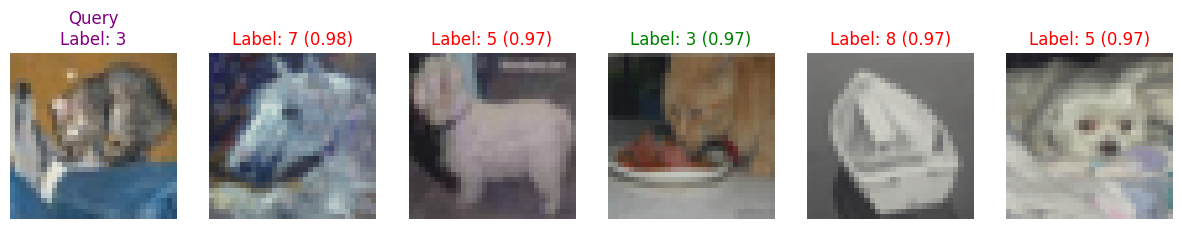

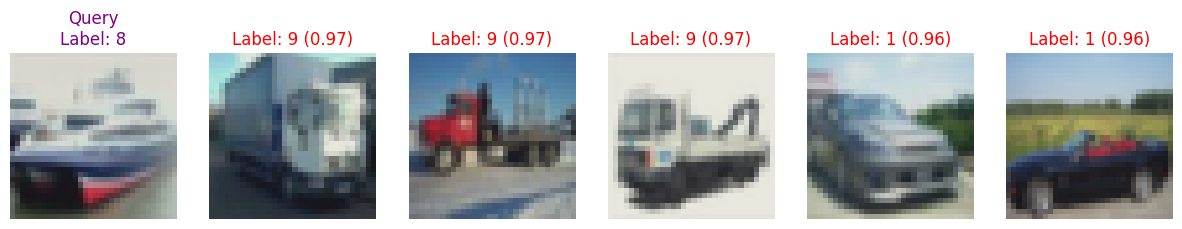

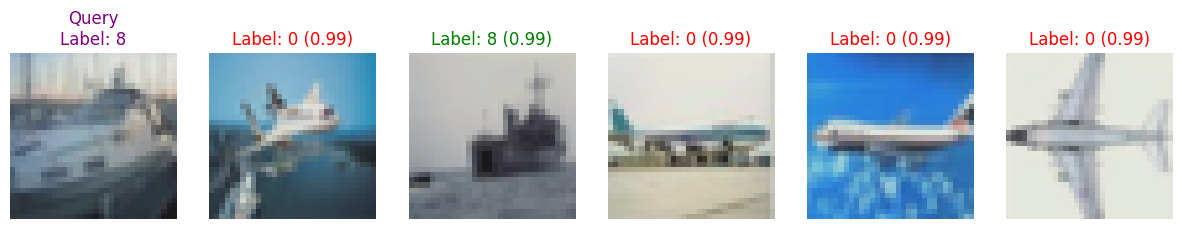

<ipython-input-5-084d5b8ceea8>:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
2024-11-16 09:52:37,744 - INFO - E

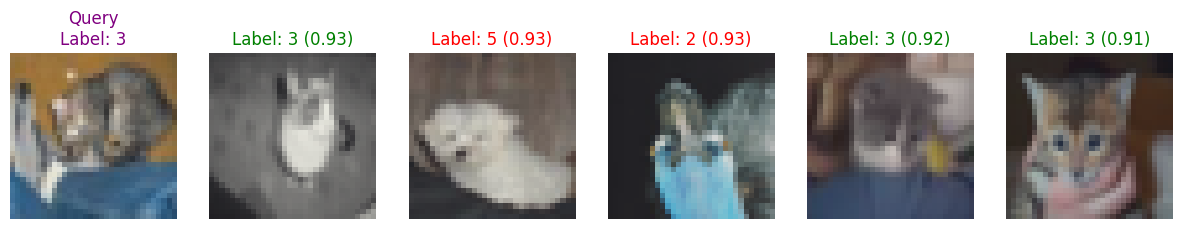

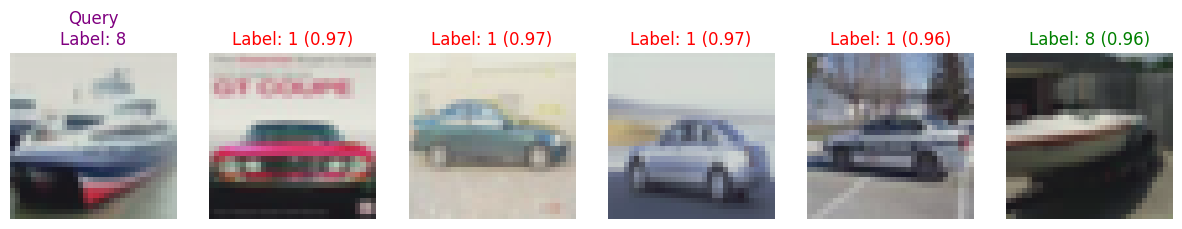

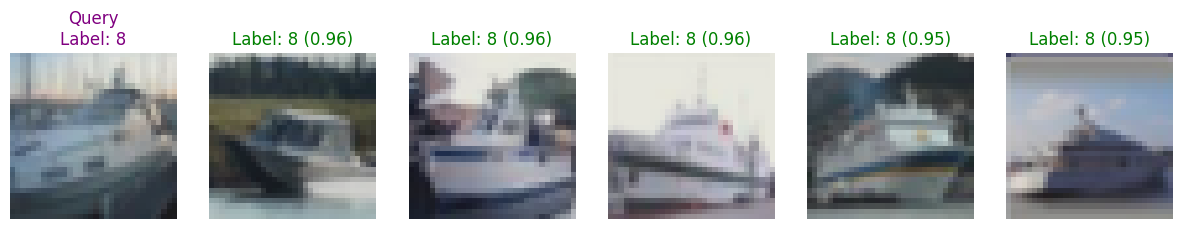

<ipython-input-5-084d5b8ceea8>:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
2024-11-16 09:53:43,279 - INFO - E

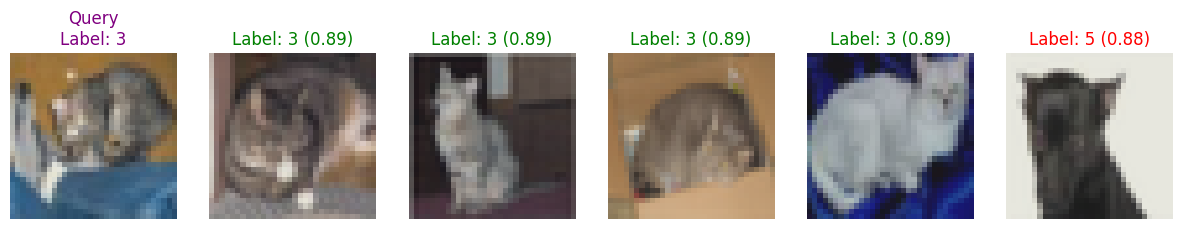

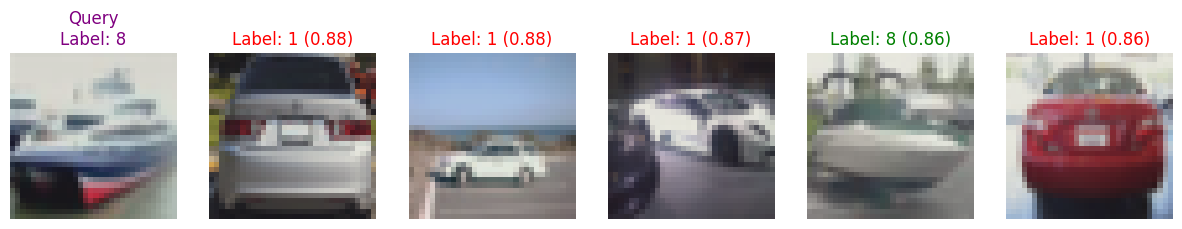

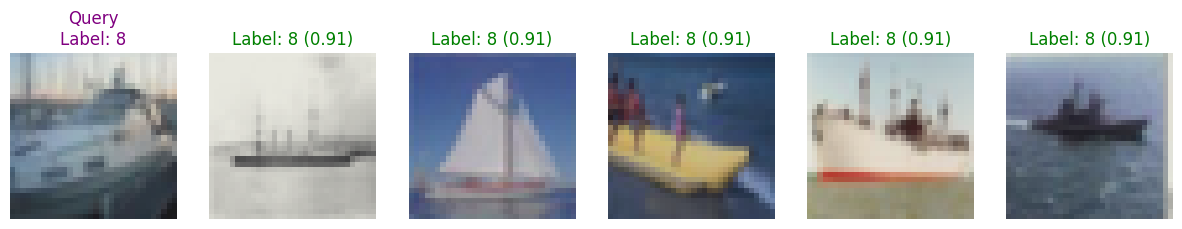

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import DataLoader
from tqdm import tqdm
from configs import settings
import logging
from core_model.custom_model import ClassifierWrapper, load_custom_model
from core_model.dataset import get_dataset_loader, BaseTensorDataset
from core_model.train_test import model_forward

# 设置设备和日志
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)


def extract_features(feature_extractor, data_loader):
    """
    提取数据的嵌入特征和标签。
    """
    features, labels = [], []
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            outputs = feature_extractor(images).view(images.size(0), -1)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    try:
        return np.concatenate(features), np.concatenate(labels)
    except ValueError:
        logger.error(
            "Error concatenating features or labels; check data loader and model output."
        )
        return None, None


def retrieve(gallery_feats, query_feats, top_k=10):
    """
    计算相似度并返回前 top-k 的索引。
    """
    try:
        sims = cosine_similarity(query_feats, gallery_feats)
        indices = np.argsort(-sims, axis=1)[:, :top_k]
        sim_scores = np.take_along_axis(sims, indices, axis=1)
        return indices, sim_scores
    except ValueError as e:
        logger.error(f"Error in similarity calculation: {e}")
        return None, None


def calculate_map(indices, gallery_labels, query_labels):
    """
    计算 mAP 值。
    """
    if indices is None:
        logger.warning("No indices to calculate mAP. Skipping.")
        return 0.0
    ap_list = []
    for i in range(len(query_labels)):
        query_label = query_labels[i]
        relevant = (gallery_labels[indices[i]] == query_label).astype(int)
        num_relevant = relevant.sum()
        if num_relevant == 0:
            ap_list.append(0)
            continue
        cumulative_precision = np.cumsum(relevant) / (np.arange(len(relevant)) + 1)
        ap = (cumulative_precision * relevant).sum() / num_relevant
        ap_list.append(ap)
    return np.mean(ap_list) if ap_list else 0.0


def visualize_retrieval(
    query_data,
    query_labels,
    gallery_data,
    gallery_labels,
    query_idx,
    retrieved_indices,
    sim_scores,
    dataset_name="cifar-10",
):
    """
    可视化检索结果，将查询图像与检索结果并列显示。
    """
    if retrieved_indices is None or sim_scores is None:
        logger.warning("No retrieval results to display. Skipping visualization.")
        return

    fig, axs = plt.subplots(1, len(retrieved_indices) + 1, figsize=(15, 3))

    # 处理查询图像
    query_img = recover_img(query_data[query_idx], dataset_name)
    axs[0].imshow(np.transpose(query_img, (1, 2, 0)))
    axs[0].set_title(f"Query\nLabel: {query_labels[query_idx]}", color="purple")
    axs[0].axis("off")

    # 处理检索结果
    for i, idx in enumerate(retrieved_indices):
        img = recover_img(gallery_data[idx], dataset_name)
        label = gallery_labels[idx]
        axs[i + 1].imshow(np.transpose(img, (1, 2, 0)))
        axs[i + 1].set_title(
            f"Label: {label} ({sim_scores[i]:.2f})",
            color="green" if label == query_labels[query_idx] else "red",
        )
        axs[i + 1].axis("off")

    plt.show()


def recover_img(img, dataset_name):
    """
    恢复归一化的图像，用于可视化。
    """
    if dataset_name == "cifar-10":
        means, stds = (
            np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis],
            np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis],
        )
    elif dataset_name == "cifar-100":
        means, stds = (
            np.array([0.5071, 0.4865, 0.4409])[:, np.newaxis, np.newaxis],
            np.array([0.2673, 0.2564, 0.2762])[:, np.newaxis, np.newaxis],
        )
    elif dataset_name == "pet-37":
        means, stds = (
            np.array([0.485, 0.456, 0.406])[:, np.newaxis, np.newaxis],
            np.array([0.229, 0.224, 0.225])[:, np.newaxis, np.newaxis],
        )
    else:
        raise NotImplementedError(
            f"Normalization for dataset {dataset_name} not implemented."
        )
    return np.clip(img * stds + means, 0, 1)


def evaluate_image_retrieval(
    dataset_name,
    model_name,
    noise_ratio,
    noise_type="symmetric",
    methods=None,
    top_k=5,
    query_indices=None,
):
    """
    执行图像检索任务，包括 mAP 计算和检索结果的可视化。
    """
    assert methods is not None, "请指定方法列表"
    assert query_indices is not None, "请指定查询索引列表"

    case = settings.get_case(noise_ratio, noise_type)
    num_classes = settings.num_classes_dict[dataset_name]

    # 加载数据集
    train_data, train_labels, train_loader = get_dataset_loader(
        dataset_name, "train", None, None, batch_size=64, shuffle=False
    )
    test_data, test_labels, test_loader = get_dataset_loader(
        dataset_name, "test", None, None, batch_size=64, shuffle=False
    )

    for method in methods:
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)

        # 加载模型权重
        model_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{noise_type}_cvpr/{method}/{model_name}_restore.pth"
        try:
            checkpoint = torch.load(model_path, map_location=device)
            model.load_state_dict(checkpoint, strict=False)
            logger.info(f"Evaluating model at {model_path}")
        except FileNotFoundError:
            logger.warning(
                f"Model checkpoint {model_path} not found. Skipping method {method}."
            )
            continue

        # 提取特征
        feature_extractor = nn.Sequential(*list(model.children())[:-1]).to(device)
        g_features, g_labels = extract_features(feature_extractor, train_loader)
        q_features, q_labels = extract_features(feature_extractor, test_loader)

        if g_features is None or q_features is None:
            logger.warning("Feature extraction failed; skipping this method.")
            continue

        # 计算 mAP
        indices, sim_scores = retrieve(g_features, q_features, top_k)
        mAP = calculate_map(indices, g_labels, q_labels)
        logger.info(f"mAP for method {method}: {mAP:.4f}")

        # 可视化检索结果
        for query_idx in query_indices:
            retrieved_indices, sim_scores = retrieve(
                g_features, q_features[query_idx : query_idx + 1], top_k
            )
            if retrieved_indices is not None and sim_scores is not None:
                visualize_retrieval(
                    test_data,
                    test_labels,
                    train_data,
                    train_labels,
                    query_idx,
                    retrieved_indices[0],
                    sim_scores[0],
                    dataset_name,
                )


# 示例用法
if __name__ == "__main__":
    dataset_name = "cifar-10"
    model_name = "efficientnet_s"
    noise_ratio = 0.1
    noise_type = "symmetric"
    methods = ["Coteaching", "Coteachingplus", "JoCoR"]
    query_indices = [0, 1, 2]  # 测试图片索引
    evaluate_image_retrieval(
        dataset_name,
        model_name,
        noise_ratio,
        noise_type,
        methods=methods,
        top_k=5,
        query_indices=query_indices,
    )

## 1. Precision@k (精度@k)

In [12]:
def evaluate_image_retrieval(
    dataset_name,
    model_name,
    noise_ratio,
    noise_type="symmetric",
    methods=None,
    top_k=5,
    query_indices=None,
):
    """
    执行图像检索任务，包括 mAP 计算、Precision@k、Recall@k、Top-k Accuracy、MRR 和 NDCG 的计算，
    以及检索结果的可视化。
    """
    assert methods is not None, "请指定方法列表"
    assert query_indices is not None, "请指定查询索引列表"

    case = settings.get_case(noise_ratio, noise_type)
    num_classes = settings.num_classes_dict[dataset_name]

    # 加载数据集
    train_data, train_labels, train_loader = get_dataset_loader(
        dataset_name, "train", None, None, batch_size=64, shuffle=False
    )
    test_data, test_labels, test_loader = get_dataset_loader(
        dataset_name, "test", None, None, batch_size=64, shuffle=False
    )

    for method in methods:
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)

        # 加载模型权重
        model_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{noise_type}_cvpr/{method}/{model_name}_restore.pth"
        try:
            checkpoint = torch.load(model_path, map_location=device)
            model.load_state_dict(checkpoint, strict=False)
            logger.info(f"Evaluating model at {model_path}")
        except FileNotFoundError:
            logger.warning(
                f"Model checkpoint {model_path} not found. Skipping method {method}."
            )
            continue

        # 提取特征
        feature_extractor = nn.Sequential(*list(model.children())[:-1]).to(device)
        g_features, g_labels = extract_features(feature_extractor, train_loader)
        q_features, q_labels = extract_features(feature_extractor, test_loader)

        if g_features is None or q_features is None:
            logger.warning("Feature extraction failed; skipping this method.")
            continue

        # 计算 mAP
        indices, sim_scores = retrieve(g_features, q_features, top_k)
        mAP = calculate_map(indices, g_labels, q_labels)
        logger.info(f"mAP for method {method}: {mAP:.4f}")

        # 计算 Precision@k
        precision_k = calculate_precision_at_k(indices, g_labels, q_labels, top_k)
        logger.info(f"Precision@{top_k} for method {method}: {precision_k:.4f}")

        # 可视化检索结果
        for query_idx in query_indices:
            retrieved_indices, sim_scores = retrieve(
                g_features, q_features[query_idx : query_idx + 1], top_k
            )
            if retrieved_indices is not None and sim_scores is not None:
                visualize_retrieval(
                    test_data,
                    test_labels,
                    train_data,
                    train_labels,
                    query_idx,
                    retrieved_indices[0],
                    sim_scores[0],
                    dataset_name,
                )

In [13]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from configs import settings
import logging
from core_model.custom_model import ClassifierWrapper, load_custom_model
from core_model.dataset import get_dataset_loader

# 设置设备和日志
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)


def extract_features(feature_extractor, data_loader):
    features, labels = [], []
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            outputs = feature_extractor(images).view(images.size(0), -1)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    return np.concatenate(features), np.concatenate(labels)


def retrieve(gallery_feats, query_feats, top_k=10):
    sims = cosine_similarity(query_feats, gallery_feats)
    indices = np.argsort(-sims, axis=1)[:, :top_k]
    sim_scores = np.take_along_axis(sims, indices, axis=1)
    return indices, sim_scores


def calculate_precision_at_k(indices, gallery_labels, query_labels, k=5):
    precision_list = []
    for i in range(len(query_labels)):
        query_label = query_labels[i]
        relevant = (gallery_labels[indices[i, :k]] == query_label).astype(int)
        precision_k = relevant.sum() / k
        precision_list.append(precision_k)
    return np.mean(precision_list)


def calculate_map(indices, gallery_labels, query_labels):
    ap_list = []
    for i in range(len(query_labels)):
        query_label = query_labels[i]
        relevant = (gallery_labels[indices[i]] == query_label).astype(int)
        num_relevant = relevant.sum()
        if num_relevant == 0:
            ap_list.append(0)
            continue
        cumulative_precision = np.cumsum(relevant) / (np.arange(len(relevant)) + 1)
        ap = (cumulative_precision * relevant).sum() / num_relevant
        ap_list.append(ap)
    return np.mean(ap_list)


def evaluate_image_retrieval(
    dataset_name,
    model_name,
    noise_ratio,
    noise_type="symmetric",
    methods=None,
    top_k=5,
    query_indices=None,
):
    assert methods is not None, "请指定方法列表"
    assert query_indices is not None, "请指定查询索引列表"

    case = settings.get_case(noise_ratio, noise_type)
    num_classes = settings.num_classes_dict[dataset_name]

    train_data, train_labels, train_loader = get_dataset_loader(
        dataset_name, "train", None, None, batch_size=64, shuffle=False
    )
    test_data, test_labels, test_loader = get_dataset_loader(
        dataset_name, "test", None, None, batch_size=64, shuffle=False
    )

    for method in methods:
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)
        model_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{noise_type}_cvpr/{method}/{model_name}_restore.pth"
        try:
            checkpoint = torch.load(model_path, map_location=device)
            model.load_state_dict(checkpoint, strict=False)
            logger.info(f"Evaluating model at {model_path}")
        except FileNotFoundError:
            logger.warning(
                f"Model checkpoint {model_path} not found. Skipping method {method}."
            )
            continue

        feature_extractor = nn.Sequential(*list(model.children())[:-1]).to(device)
        g_features, g_labels = extract_features(feature_extractor, train_loader)
        q_features, q_labels = extract_features(feature_extractor, test_loader)

        if g_features is None or q_features is None:
            logger.warning("Feature extraction failed; skipping this method.")
            continue

        indices, sim_scores = retrieve(g_features, q_features, top_k)

        # Calculate mAP
        mAP = calculate_map(indices, g_labels, q_labels)
        logger.info(f"mAP for method {method}: {mAP:.4f}")

        # Calculate Precision@k
        precision_k = calculate_precision_at_k(indices, g_labels, q_labels, top_k)
        logger.info(f"Precision@{top_k} for method {method}: {precision_k:.4f}")


if __name__ == "__main__":
    dataset_name = "cifar-10"
    model_name = "efficientnet_s"
    noise_ratio = 0.1
    noise_type = "symmetric"
    methods = ["Coteaching", "Coteachingplus", "JoCoR"]
    query_indices = [0, 1, 2]  # 示例测试图片索引

    evaluate_image_retrieval(
        dataset_name,
        model_name,
        noise_ratio,
        noise_type,
        methods=methods,
        top_k=5,
        query_indices=query_indices,
    )

Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/train_data.npy
Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/test_data.npy


<ipython-input-13-01099132136c>:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
2024-11-16 10:25:11,740 - INFO - E

## 1. Precision@k (精度@k)

In [ ]:
def calculate_precision_at_k(indices, gallery_labels, query_labels, k=5):
    """
    计算前 k 个检索结果的精度 (Precision@k)。
    """
    precision_list = []
    for i in range(len(query_labels)):
        query_label = query_labels[i]
        relevant = (gallery_labels[indices[i, :k]] == query_label).astype(int)
        precision_k = relevant.sum() / k
        precision_list.append(precision_k)
    return np.mean(precision_list)

## 2. Recall@k (召回率@k)

In [14]:
def calculate_recall_at_k(indices, gallery_labels, query_labels, k=5):
    """
    计算前 k 个检索结果的召回率 (Recall@k)。
    """
    recall_list = []
    for i in range(len(query_labels)):
        query_label = query_labels[i]
        relevant = (gallery_labels == query_label).astype(int)
        num_relevant = relevant.sum()
        if num_relevant == 0:
            recall_list.append(0)
            continue
        top_k_relevant = (gallery_labels[indices[i, :k]] == query_label).astype(int)
        recall_k = top_k_relevant.sum() / num_relevant
        recall_list.append(recall_k)
    return np.mean(recall_list)
# recall_k = calculate_recall_at_k(indices, g_labels, q_labels, top_k)
# logger.info(f"Recall@{top_k} for method {method}: {recall_k:.4f}")


## 3. Top-k Accuracy (Top-k 准确率)

In [15]:
def calculate_top_k_accuracy(indices, gallery_labels, query_labels, k=5):
    """
    计算 Top-k 准确率。
    """
    correct = 0
    for i in range(len(query_labels)):
        query_label = query_labels[i]
        if query_label in gallery_labels[indices[i, :k]]:
            correct += 1
    return correct / len(query_labels)

# top_k_accuracy = calculate_top_k_accuracy(indices, g_labels, q_labels, top_k)
# logger.info(f"Top-{top_k} Accuracy for method {method}: {top_k_accuracy:.4f}")


## 4. Mean Reciprocal Rank (MRR)

In [16]:
def calculate_mrr(indices, gallery_labels, query_labels):
    """
    计算平均互反排名 (MRR)。
    """
    reciprocal_ranks = []
    for i in range(len(query_labels)):
        query_label = query_labels[i]
        relevant_ranks = np.where(gallery_labels[indices[i]] == query_label)[0]
        if relevant_ranks.size > 0:
            reciprocal_ranks.append(1 / (relevant_ranks[0] + 1))
        else:
            reciprocal_ranks.append(0)
    return np.mean(reciprocal_ranks)

# mrr = calculate_mrr(indices, g_labels, q_labels)
# logger.info(f"MRR for method {method}: {mrr:.4f}")


## 5. Normalized Discounted Cumulative Gain (NDCG)

In [17]:
def calculate_ndcg(indices, gallery_labels, query_labels, k=5):
    """
    计算前 k 个检索结果的归一化折扣累积增益 (NDCG)。
    """
    ndcg_list = []
    for i in range(len(query_labels)):
        query_label = query_labels[i]
        relevance = (gallery_labels[indices[i, :k]] == query_label).astype(int)
        gains = (2**relevance - 1) / np.log2(np.arange(2, k + 2))
        ideal_gains = (2**np.ones(relevance.sum()) - 1) / np.log2(np.arange(2, relevance.sum() + 2))
        ndcg = gains.sum() / (ideal_gains.sum() if ideal_gains.size > 0 else 1)
        ndcg_list.append(ndcg)
    return np.mean(ndcg_list)

# ndcg_k = calculate_ndcg(indices, g_labels, q_labels, top_k)
# logger.info(f"NDCG@{top_k} for method {method}: {ndcg_k:.4f}")


## 汇总代码

In [18]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import pandas as pd
from configs import settings
import logging
from core_model.custom_model import ClassifierWrapper, load_custom_model
from core_model.dataset import get_dataset_loader

# 设置设备和日志
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)


def extract_features(feature_extractor, data_loader):
    features, labels = [], []
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            outputs = feature_extractor(images).view(images.size(0), -1)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    return np.concatenate(features), np.concatenate(labels)


def retrieve(gallery_feats, query_feats, top_k=10):
    sims = cosine_similarity(query_feats, gallery_feats)
    indices = np.argsort(-sims, axis=1)[:, :top_k]
    sim_scores = np.take_along_axis(sims, indices, axis=1)
    return indices, sim_scores


def calculate_precision_at_k(indices, gallery_labels, query_labels, k=5):
    precision_list = []
    for i in range(len(query_labels)):
        query_label = query_labels[i]
        relevant = (gallery_labels[indices[i, :k]] == query_label).astype(int)
        precision_k = relevant.sum() / k
        precision_list.append(precision_k)
    return np.mean(precision_list)


def calculate_recall_at_k(indices, gallery_labels, query_labels, k=5):
    recall_list = []
    for i in range(len(query_labels)):
        query_label = query_labels[i]
        relevant = (gallery_labels == query_label).astype(int)
        num_relevant = relevant.sum()
        if num_relevant == 0:
            recall_list.append(0)
            continue
        top_k_relevant = (gallery_labels[indices[i, :k]] == query_label).astype(int)
        recall_k = top_k_relevant.sum() / num_relevant
        recall_list.append(recall_k)
    return np.mean(recall_list)


def calculate_top_k_accuracy(indices, gallery_labels, query_labels, k=5):
    correct = 0
    for i in range(len(query_labels)):
        query_label = query_labels[i]
        if query_label in gallery_labels[indices[i, :k]]:
            correct += 1
    return correct / len(query_labels)


def calculate_mrr(indices, gallery_labels, query_labels):
    reciprocal_ranks = []
    for i in range(len(query_labels)):
        query_label = query_labels[i]
        relevant_ranks = np.where(gallery_labels[indices[i]] == query_label)[0]
        if relevant_ranks.size > 0:
            reciprocal_ranks.append(1 / (relevant_ranks[0] + 1))
        else:
            reciprocal_ranks.append(0)
    return np.mean(reciprocal_ranks)


def calculate_ndcg(indices, gallery_labels, query_labels, k=5):
    ndcg_list = []
    for i in range(len(query_labels)):
        query_label = query_labels[i]
        relevance = (gallery_labels[indices[i, :k]] == query_label).astype(int)
        gains = (2**relevance - 1) / np.log2(np.arange(2, k + 2))
        ideal_gains = (2 ** np.ones(relevance.sum()) - 1) / np.log2(
            np.arange(2, relevance.sum() + 2)
        )
        ndcg = gains.sum() / (ideal_gains.sum() if ideal_gains.size > 0 else 1)
        ndcg_list.append(ndcg)
    return np.mean(ndcg_list)


def calculate_map(indices, gallery_labels, query_labels):
    ap_list = []
    for i in range(len(query_labels)):
        query_label = query_labels[i]
        relevant = (gallery_labels[indices[i]] == query_label).astype(int)
        num_relevant = relevant.sum()
        if num_relevant == 0:
            ap_list.append(0)
            continue
        cumulative_precision = np.cumsum(relevant) / (np.arange(len(relevant)) + 1)
        ap = (cumulative_precision * relevant).sum() / num_relevant
        ap_list.append(ap)
    return np.mean(ap_list)


def evaluate_image_retrieval(
    dataset_name,
    model_name,
    noise_ratio,
    noise_type="symmetric",
    methods=None,
    top_k=5,
    query_indices=None,
):
    assert methods is not None, "请指定方法列表"
    assert query_indices is not None, "请指定查询索引列表"

    case = settings.get_case(noise_ratio, noise_type)
    num_classes = settings.num_classes_dict[dataset_name]
    results = []

    train_data, train_labels, train_loader = get_dataset_loader(
        dataset_name, "train", None, None, batch_size=64, shuffle=False
    )
    test_data, test_labels, test_loader = get_dataset_loader(
        dataset_name, "test", None, None, batch_size=64, shuffle=False
    )

    for method in methods:
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)
        model_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{noise_type}_cvpr/{method}/{model_name}_restore.pth"
        try:
            checkpoint = torch.load(model_path, map_location=device)
            model.load_state_dict(checkpoint, strict=False)
            logger.info(f"Evaluating model at {model_path}")
        except FileNotFoundError:
            logger.warning(
                f"Model checkpoint {model_path} not found. Skipping method {method}."
            )
            continue

        feature_extractor = nn.Sequential(*list(model.children())[:-1]).to(device)
        g_features, g_labels = extract_features(feature_extractor, train_loader)
        q_features, q_labels = extract_features(feature_extractor, test_loader)

        if g_features is None or q_features is None:
            logger.warning("Feature extraction failed; skipping this method.")
            continue

        indices, sim_scores = retrieve(g_features, q_features, top_k)

        # Calculate all metrics
        mAP = calculate_map(indices, g_labels, q_labels)
        precision_k = calculate_precision_at_k(indices, g_labels, q_labels, top_k)
        recall_k = calculate_recall_at_k(indices, g_labels, q_labels, top_k)
        top_k_accuracy = calculate_top_k_accuracy(indices, g_labels, q_labels, top_k)
        mrr = calculate_mrr(indices, g_labels, q_labels)
        ndcg_k = calculate_ndcg(indices, g_labels, q_labels, top_k)

        logger.info(
            f"{method}: mAP={mAP:.4f}, Precision@{top_k}={precision_k:.4f}, Recall@{top_k}={recall_k:.4f}, Top-{top_k} Accuracy={top_k_accuracy:.4f}, MRR={mrr:.4f}, NDCG@{top_k}={ndcg_k:.4f}"
        )

        # Store results
        results.append(
            {
                "Method": method,
                "mAP": mAP,
                f"Precision@{top_k}": precision_k,
                f"Recall@{top_k}": recall_k,
                f"Top-{top_k} Accuracy": top_k_accuracy,
                "MRR": mrr,
                f"NDCG@{top_k}": ndcg_k,
            }
        )

    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv("retrieval_results.csv", index=False)
    logger.info("Results saved to retrieval_results.csv")


if __name__ == "__main__":
    dataset_name = "cifar-10"
    model_name = "efficientnet_s"
    noise_ratio = 0.1
    noise_type = "symmetric"
    methods = ["Coteaching", "Coteachingplus", "JoCoR"]
    query_indices = [0, 1, 2]  # 示例测试图片索引

    evaluate_image_retrieval(
        dataset_name,
        model_name,
        noise_ratio,
        noise_type,
        methods=methods,
        top_k=5,
        query_indices=query_indices,
    )

Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/train_data.npy
Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/test_data.npy


<ipython-input-18-b2d0bd62cf25>:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
2024-11-16 10:41:12,779 - INFO - 